In [ ]:
from datasets import load_dataset
datasets = load_dataset("Anthropic/hh-rlhf", data_dir="harmless-base")
datasets

In [ ]:
instance = datasets["train"][0]['chosen']
# Split by both 'Human' and "Assistant"
dialogue_list = instance.split('\n\n')
dialogue_list = [dialogue.strip() for dialogue in dialogue_list if dialogue.strip() != '']
res = []
for dialogue in dialogue_list:
    print(dialogue)
    if dialogue.startswith('Human:'): 
        res.append(dialogue.lstrip('Human:').strip())
    elif dialogue.startswith('Assistant'):
        res.append(dialogue.lstrip('Assistant:').strip())
    else:
        res[-1] += '\n\n' + dialogue
        
print(res)

In [1]:
from datasets import load_dataset

datasets = load_dataset('data/Anthropic')
datasets

/home/yuli/anaconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['query', 'reference'],
        num_rows: 104054
    })
    test: Dataset({
        features: ['query', 'reference'],
        num_rows: 5756
    })
})

In [2]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM

config = AutoConfig.from_pretrained("microsoft/DialoGPT-small")
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small", config=config)

In [3]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['query'], 
        padding=False, 
        truncation=True,
    )
    labels = tokenizer(
        examples['reference'], 
        padding=False, 
        truncation=True,
        
    )
    tokenized_inputs['labels'] = labels['input_ids']
    # tokenized_inputs['labels_attention_mask'] = labels['attention_mask']
    return tokenized_inputs

train_dataset = datasets['train'].map(
    tokenize_and_align_labels,
    batched=True,
).remove_columns(datasets['train'].column_names)
# sample  300 examples
train_dataset = train_dataset.select(range(300))

train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 300
})

In [4]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForSeq2Seq

label_pad_token_id = tokenizer.pad_token_id
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=None,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=3,
    collate_fn=data_collator,
    shuffle=True,
)
# inputs = next(iter(train_dataloader))
# print(inputs)

2024-02-09 10:28:47.002895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 10:28:47.150089: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-09 10:28:47.150122: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-09 10:28:47.833078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [8]:
import sys 
sys.dont_write_bytecode = True
from models import _prepare_decoding_inputs
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=100,
)
new_inputs = _prepare_decoding_inputs(inputs)

# Forward pass for CLM
outputs = model(**new_inputs)
loss = outputs.loss
print('decoding loss: ', loss)
loss.backward()

# Update optimizer and scheduler
optimizer.step()

# Update learning rate
scheduler.step()

# Clear gradients
optimizer.zero_grad()

# Another forward pass for CLM
outputs = model(**new_inputs)
loss = outputs.loss
print('decoding loss: ', loss)

/home/yuli/anaconda3/envs/py3.10/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


decoding loss:  tensor(4.9014, grad_fn=<NllLossBackward0>)
decoding loss:  tensor(2.4446, grad_fn=<NllLossBackward0>)


In [7]:
import torch
from typing import Iterable
from models import get_stages, stages_decoding
from collections import defaultdict
import sys 
sys.dont_write_bytecode = True
from transformers import get_scheduler

stages = get_stages(
    config=config,
    token=None,
    model_name_or_path="microsoft/DialoGPT-small",
    num_stages=4,
    init_device=0,
    timing_info=defaultdict(list),
)
# stages is a list of GPT2LMHeadModel
# This time: define optimizer and scheduler in this case
# Collect all parameters from each stage
all_parameters = []
for stage in stages:
    all_parameters.extend(list(stage.parameters()))
optimizer = torch.optim.AdamW(all_parameters, lr=1e-4)
    
schedulers = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=100,
)
losses = []

@torch.no_grad()
def custom_step(lr: float):
    """
    Applies a simple gradient descent update to the parameters.

    Args:
        parameters (Iterable[torch.nn.Parameter]): An iterable of Parameters to update.
        lr (float): The learning rate to use for the update.
    """
    # with torch.no_grad():  # Ensure gradients are not tracked in this operation
    #     for param in parameters:
    #         if param.grad is not None:  # Skip parameters without gradients
    #             param -= lr * param.grad  # Update parameter using gradient descent
    for stage in stages:
        for param in stage.parameters():
            if param.grad is not None:
                # Manually update the model parameters using the gradient descent rule
                # param.data = param.data - learning_rate * param.grad
                param -= lr * param.grad

# Let's use 100 steps for demonstration
for inputs in train_dataloader:
    inputs = next(iter(train_dataloader))
    outputs = stages_decoding(stages, inputs)
    loss = outputs[0]
    losses.append(loss.item())
    print('decoding loss: ', loss)
    loss.backward()

    # Update optimizer and scheduler
    # print(optimizer.state_dict())
    optimizer.step()
    # Using custom step
    # custom_step(schedulers.get_last_lr()[0])

    # Update learning rate
    schedulers.step()

    # Clear gradients
    optimizer.zero_grad()

print('average loss: ', sum(losses) / len(losses))


Put stage GPTStartingStage (60647424 parameters) on device 0
Put stage GPTIntermediateStage (21263616 parameters) on device 1
Put stage GPTIntermediateStage (21263616 parameters) on device 2
Put stage GPTEndingStage (59862528 parameters) on device 3
Forward pass for stage 0 on device 0
Forward pass for stage 1 on device 1
Forward pass for stage 2 on device 2
Forward pass for stage 3 on device 3
decoding loss:  tensor(6.1026, device='cuda:3', grad_fn=<BackwardHookFunctionBackward>)
Forward pass for stage 0 on device 0
Forward pass for stage 1 on device 1
Forward pass for stage 2 on device 2
Forward pass for stage 3 on device 3
decoding loss:  tensor(4.0280, device='cuda:3', grad_fn=<BackwardHookFunctionBackward>)
Forward pass for stage 0 on device 0
Forward pass for stage 1 on device 1
Forward pass for stage 2 on device 2
Forward pass for stage 3 on device 3
decoding loss:  tensor(5.0473, device='cuda:3', grad_fn=<BackwardHookFunctionBackward>)
Forward pass for stage 0 on device 0
Forwa

In [14]:
# optimizer.state_dict()

## Analysis

In [22]:
import json
from collections import defaultdict

retrain_0_node0 = json.load(open("prof_async/timing_info_dialogpt_active_poisson_0.3_node0.json"))
retrain_0_node1 = json.load(open("prof_async/timing_info_dialogpt_active_poisson_0.3_node1.json"))

global_min_time, global_max_time = float('inf'), float('-inf')
metrics = defaultdict(list)
total_idles = []
total_latencies = []
for nodeID, timing_info in enumerate([retrain_0_node0, retrain_0_node1]):          
    print("Timing info: ", timing_info)
    
    for gpu_id in range(len(timing_info)//2):
        min_t, max_t = float('inf'), float('-inf')
        gpu_idx = nodeID * len(timing_info)//2 + gpu_id
        starts = timing_info.get(f"{gpu_idx}_start", [])
        ends = timing_info.get(f"{gpu_idx}_end", [])
        # print([(start - end, (start, start_label), (end, end_label)) for (start, start_label), (end, end_label) in list(zip(starts[1:], ends[:-1])) if (start_label == end_label and start > end)])
        # print([(start - end, (start, start_label), (end, end_label)) for (start, start_label), (end, end_label) in list(zip(starts[1:], ends[:-1])) if (start <= end)])
        if len(starts) == 1:
            idles = [0]
        else:
            idles = [start - end for (start, start_label), (end, end_label) in zip(starts[1:], ends[:-1]) if (start_label == end_label and start > end)]
        total_idles.extend(idles)
        
        tasks = list(zip(starts, ends))
        for i, ((start, start_label), (end, _)) in enumerate(tasks):
            metrics[start_label].append(end - start)
            min_t = min(min_t, start)
            max_t = max(max_t, end)
        total_latencies.append(max_t - min_t)
        global_min_time = min(global_min_time, min_t)
        global_max_time = max(global_max_time, max_t)
        
num_tasks = 200
bubble_rate = sum(total_idles) / sum(total_latencies) if sum(total_latencies) > 0 else 0
for key, value in metrics.items():
    metrics[key] = sum(value) / len(value)

metrics['num_tasks'] = num_tasks
metrics['bubble_rate'] = bubble_rate 
metrics['idleness'] = sum(total_idles) / len(total_idles)
metrics['response_time'] = sum(total_latencies) * 2 / (num_tasks * len(total_latencies))
metrics['throughput'] = num_tasks / (global_max_time - global_min_time)

print(metrics)

Timing info:  {'0_start': [[1707543569.4861276, 'forward'], [1707543569.9354758, 'forward_grad'], [1707543569.9586496, 'forward'], [1707543569.9644957, 'forward'], [1707543569.983612, 'forward'], [1707543569.9892833, 'forward'], [1707543570.0011601, 'forward'], [1707543570.0096648, 'forward'], [1707543570.0190809, 'forward'], [1707543570.0308545, 'forward'], [1707543570.044564, 'forward_grad'], [1707543570.0676162, 'forward'], [1707543570.081959, 'forward'], [1707543570.1008205, 'forward'], [1707543570.1184008, 'forward'], [1707543570.1393187, 'forward'], [1707543570.1674106, 'forward'], [1707543570.1966827, 'forward'], [1707543570.2133698, 'forward'], [1707543570.3065107, 'forward_grad'], [1707543570.328785, 'backward'], [1707543570.3445973, 'forward'], [1707543570.3821297, 'forward_grad'], [1707543570.4216254, 'forward'], [1707543570.4778264, 'forward_grad'], [1707543570.4951992, 'forward'], [1707543570.522243, 'forward_grad'], [1707543570.55098, 'forward_grad'], [1707543570.6013567,

In [40]:
import pandas as pd
res = []

for retrain_rate in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    metric = json.load(open(f"prof_async/metrics_dialogpt_active_poisson_{retrain_rate}.json"))
    metric["retrain_rate"] = retrain_rate
    res.append(metric)
    
res = pd.DataFrame(res)
res

,loss,forward,num_tasks,bubble_rate,idleness,response_time,end2end_latency,throughput,retrain_rate,forward_grad,backward
0,5.778933,0.031766,200,0.105760,0.003795,0.035522,4.172009,47.938530,0.0,NaN,NaN
1,4.532257,0.032636,200,0.319061,0.016694,0.037345,4.219622,47.397606,0.1,0.038044,0.050929
2,4.161509,0.057247,200,0.116658,0.009622,0.035983,4.485580,44.587322,0.2,0.066151,0.102749
3,4.199733,0.063669,200,0.134932,0.011317,0.037742,4.468024,44.762522,0.3,0.059253,0.149221
4,4.045019,0.082275,200,0.100755,0.011409,0.038499,4.757497,42.038914,0.4,0.090187,0.157774
5,3.856603,0.076209,200,0.031661,0.004810,0.041211,5.845704,34.213157,0.5,0.092322,0.100197
6,3.870784,0.073557,200,0.066375,0.008589,0.039143,5.363154,37.291488,0.6,0.064501,0.097973
7,3.720211,0.081056,200,0.017203,0.002826,0.049690,6.465980,30.931118,0.7,0.108845,0.115962
8,3.584259,0.080067,200,0.065451,0.008002,0.044929,6.449493,31.010191,0.8,0.099280,0.130138
9,3.531062,0.102157,200,0.021334,0.002443,0.043939,6.713315,29.791542,0.9,0.106008,0.120903


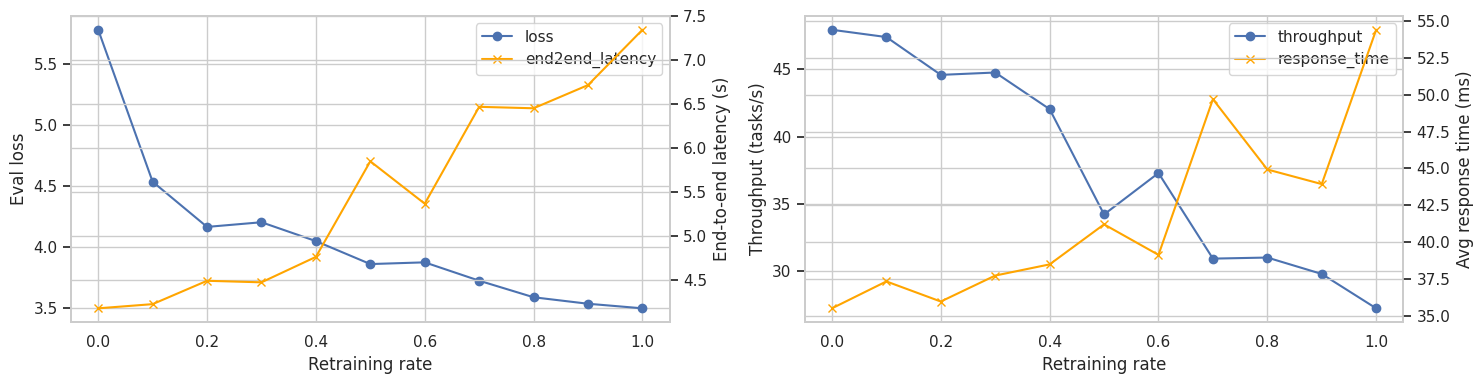

In [62]:
# Let's plot the metrics, x-axis is retrain_rate, y-axis is the metric value

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
line1, = axes[0].plot(res["retrain_rate"], res["loss"], label="loss", marker='o')
axes[0].set_ylabel("Eval loss")
ax2 = axes[0].twinx()
# line2, = ax2.plot(res["retrain_rate"], res["throughput"], label="throughput", color='orange', marker='x')
line2, = ax2.plot(res["retrain_rate"], res["end2end_latency"], label="end2end_latency", color='orange', marker='x')
ax2.set_ylabel("End-to-end latency (s)")
# ax2.legend()
lines = [line1, line2]
labels = [line.get_label() for line in lines]
# Create a single legend for both lines together
axes[0].legend(lines, labels, loc='best')
axes[0].set_xlabel("Retraining rate")

line1, = axes[1].plot(res["retrain_rate"], res["throughput"], label="throughput", marker='o')
axes[1].set_ylabel("Throughput (tasks/s)")
ax2 = axes[1].twinx()
# line2, = ax2.plot(res["retrain_rate"], res["throughput"], label="throughput", color='orange', marker='x')
line2, = ax2.plot(res["retrain_rate"], res["response_time"] * 1000, label="response_time", color='orange', marker='x')
ax2.set_ylabel("Avg response time (ms)")
# ax2.legend()
lines = [line1, line2]
labels = [line.get_label() for line in lines]
# Create a single legend for both lines together
axes[1].legend(lines, labels, loc='best')
axes[1].set_xlabel("Retraining rate")
plt.tight_layout()
plt.savefig("figure/metrics_dialogpt_active_poisson.pdf", bbox_inches='tight')
plt.show()

In [39]:
res

,loss,forward,num_tasks,bubble_rate,idleness,response_time,end2end_latency,throughput,retrain_rate,forward_grad,backward
0,5.778933,0.031766,200,0.105760,0.003795,0.035522,4.172009,47.938530,0.0,NaN,NaN
1,4.486410,0.038083,200,0.198652,0.010893,0.035231,3.972443,50.346848,0.1,0.046982,0.084288
2,4.161509,0.057247,200,0.116658,0.009622,0.035983,4.485580,44.587322,0.2,0.066151,0.102749
3,4.199733,0.063669,200,0.134932,0.011317,0.037742,4.468024,44.762522,0.3,0.059253,0.149221
4,4.045019,0.082275,200,0.100755,0.011409,0.038499,4.757497,42.038914,0.4,0.090187,0.157774
5,3.856603,0.076209,200,0.031661,0.004810,0.041211,5.845704,34.213157,0.5,0.092322,0.100197
6,3.870784,0.073557,200,0.066375,0.008589,0.039143,5.363154,37.291488,0.6,0.064501,0.097973
7,3.720211,0.081056,200,0.017203,0.002826,0.049690,6.465980,30.931118,0.7,0.108845,0.115962
8,3.584259,0.080067,200,0.065451,0.008002,0.044929,6.449493,31.010191,0.8,0.099280,0.130138
9,3.531062,0.102157,200,0.021334,0.002443,0.043939,6.713315,29.791542,0.9,0.106008,0.120903
